In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorboard import notebook
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
from gensim.models import Word2Vec
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence, Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding, LSTM, Bidirectional, GRU, GlobalMaxPool1D
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
import pydot
import IPython
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot, plot_model


In [3]:
import seaborn as sns

In [4]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

In [5]:
train = pd.read_csv('./train.csv')
#test = pd.read_csv('./test.csv')


In [6]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
train_y = train[list_classes].values
train_x= train["comment_text"]


In [7]:
np.random.seed(42)

num_samples = 80000
train_samples = 48000
val_samples = int(train_samples + ((num_samples-train_samples)/2))
samples = np.random.choice(len(train_x), num_samples)
train_X = train_x[samples[0:train_samples]]
train_Y = train_y[samples[0:train_samples]]
val_X = train_x[samples[train_samples:val_samples]]
val_Y = train_y[samples[train_samples: val_samples]]
test_X = train_x[samples[val_samples:num_samples]]
test_Y = train_y[samples[val_samples:num_samples]]

In [9]:
print(train_X.head())
print(test_X.head())

121958    You are WRONG. \n\nJustin Thompson is mentione...
146867    "\n\n British Bands?  \n\nI think you've mista...
131932    I won't stop that. Sometimes Germanic equals G...
103694    Back it up. Post the line here with the refere...
119879    REDIRECT Talk:John Loveday (experimental physi...
Name: comment_text, dtype: object
41070     G'day Mackequine, and welcome to Wikipedia!\n\...
11974     Add Media Matters back\n add Opposition to the...
114031    "==Really, guys?==\nIf you hate President Bush...
18608     Effects under £2000 - dated 24th August, 1860....
150547    "\nJust a heads up those people asking you to ...
Name: comment_text, dtype: object


In [38]:
train_y_df = pd.DataFrame(train_Y, columns=list_classes)
rowsums=train_y_df.iloc[:,0:].sum(axis=1)
train_y_df['clean']=(rowsums==0)
print(train_y_df['clean'].sum())
# Print the DataFrame
print(train_y_df)
class_counts = train_y_df.iloc[:, :-1].sum()

# Calculate the minimum count among the non-"clean" classes
max_count = class_counts[class_counts > 0].max()

# Sample rows with "clean" class to match the minimum count
clean_rows = train_y_df[train_y_df['clean']].sample(n=max_count, random_state=42)

# Filter out the "clean" rows from the original DataFrame
balanced_train_y_df = pd.concat([train_y_df[~train_y_df['clean']], clean_rows])

# Shuffle the balanced DataFrame
balanced_train_y_df = balanced_train_y_df.sample(frac=1, random_state=42)

# Print the number of rows in each class after balancing
print(balanced_train_y_df.iloc[:, :].shape)


43107
       toxic  severe_toxic  obscene  threat  insult  identity_hate  clean
0          0             0        0       0       0              0   True
1          0             0        0       0       0              0   True
2          1             0        0       0       0              0  False
3          0             0        0       0       0              0   True
4          0             0        0       0       0              0   True
...      ...           ...      ...     ...     ...            ...    ...
47995      0             0        0       0       0              0   True
47996      0             0        0       0       0              0   True
47997      0             0        0       0       0              0   True
47998      0             0        0       0       0              0   True
47999      0             0        0       0       0              0   True

[48000 rows x 7 columns]
(9514, 7)


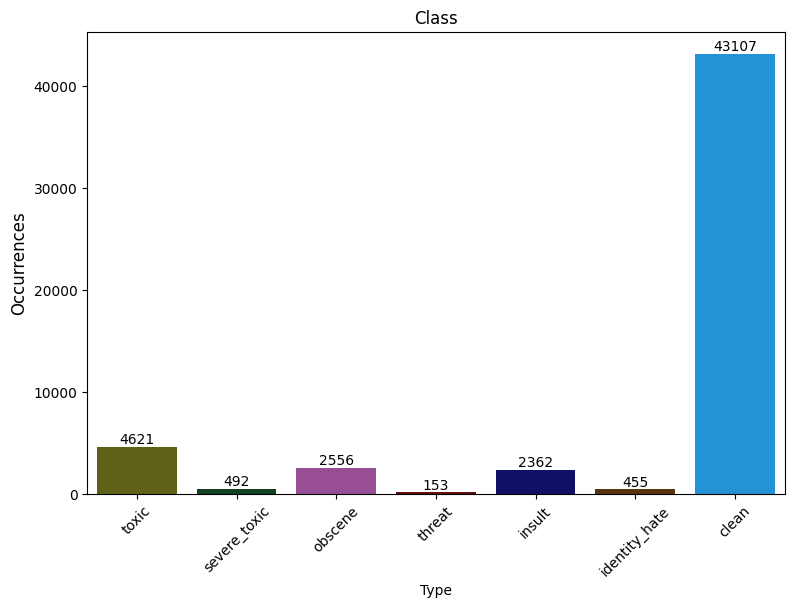

In [44]:

colors_list = ["brownish green", "pine green", "ugly purple",
               "blood", "deep blue", "brown", "azure"]

palette = sns.xkcd_palette(colors_list)

x = train_y_df.iloc[:, 0:].sum()

plt.figure(figsize=(9, 6))
ax = sns.barplot(x=x.index, y=x.values, palette=palette)
plt.title("Class")
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Type')
plt.xticks(rotation=45)
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 10, label,
            ha='center', va='bottom')

plt.show()


In [10]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
remove_n = lambda x: re.sub("\n", " ", x)
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)
train_X = train_X.map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)
val_X = val_X.map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)
test_X = test_X.map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)



In [ ]:
print(val_X)

In [10]:
max_words = 48000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_X)

In [21]:
train_sequences = []
for seq in tokenizer.texts_to_sequences_generator(train_X):
    train_sequences.append(seq)

val_sequences = []
for seq in tokenizer.texts_to_sequences_generator(val_X):
    val_sequences.append(seq)


test_sequences = []

for seq in tokenizer.texts_to_sequences_generator(test_X):
    test_sequences.append(seq)
    
def find_max_list(list):
    list_len = [len(i) for i in list]
    return (max(list_len))

max_length = max(find_max_list(train_sequences),find_max_list(val_sequences), find_max_list(test_sequences))

train_padded_X = pad_sequences(train_sequences, maxlen=int(max_length/2))
val_padded_X = pad_sequences(val_sequences, maxlen=int(max_length/2))
test_padded_X = pad_sequences(test_sequences, maxlen=int(max_length/2))

print(val_sequences[0])


In [56]:
inp = Input(shape=(int(max_length/2), ))
x = Embedding(max_words, 128)(inp)
x = LSTM(64, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.5)(x)

x = Dense(6, activation='sigmoid')(x)
model = Model(inputs=inp, outputs=x)

#print(model.summary())
model_2=Model(inputs=inp, outputs=x)
model_2.compile('adam', 'binary_crossentropy', metrics=['accuracy'])


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 700)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 700, 128)          6144000   
                                                                 
 lstm_layer (LSTM)           (None, 700, 64)           49408     
                                                                 
 global_max_pooling1d_4 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                           

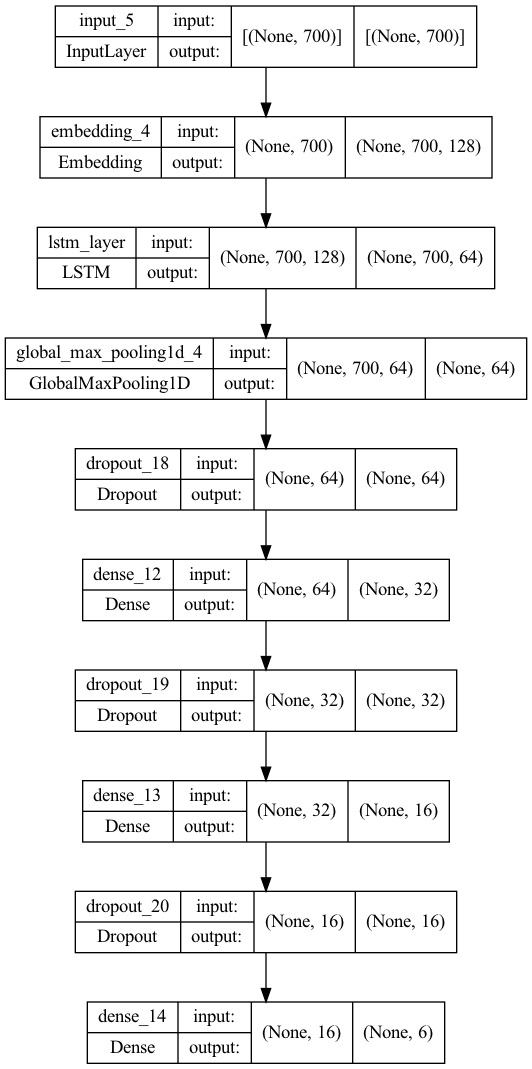

In [139]:
plot_model(model, show_shapes=True)

In [59]:
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_padded_X, train_Y,
          batch_size= 128,
          epochs=5,
          validation_data= [val_padded_X, val_Y])

Epoch 1/5
375/375 [==============================] - 345s 916ms/step - loss: 0.2606 - accuracy: 0.3185 - val_loss: 0.0873 - val_accuracy: 0.9905
Epoch 2/5
375/375 [==============================] - 344s 918ms/step - loss: 0.0864 - accuracy: 0.8133 - val_loss: 0.0592 - val_accuracy: 0.9933
Epoch 3/5
375/375 [==============================] - 342s 912ms/step - loss: 0.0612 - accuracy: 0.9566 - val_loss: 0.0578 - val_accuracy: 0.9933
Epoch 4/5
375/375 [==============================] - 346s 922ms/step - loss: 0.0529 - accuracy: 0.9749 - val_loss: 0.0595 - val_accuracy: 0.9933
Epoch 5/5
375/375 [==============================] - 350s 932ms/step - loss: 0.0473 - accuracy: 0.9822 - val_loss: 0.0586 - val_accuracy: 0.9933


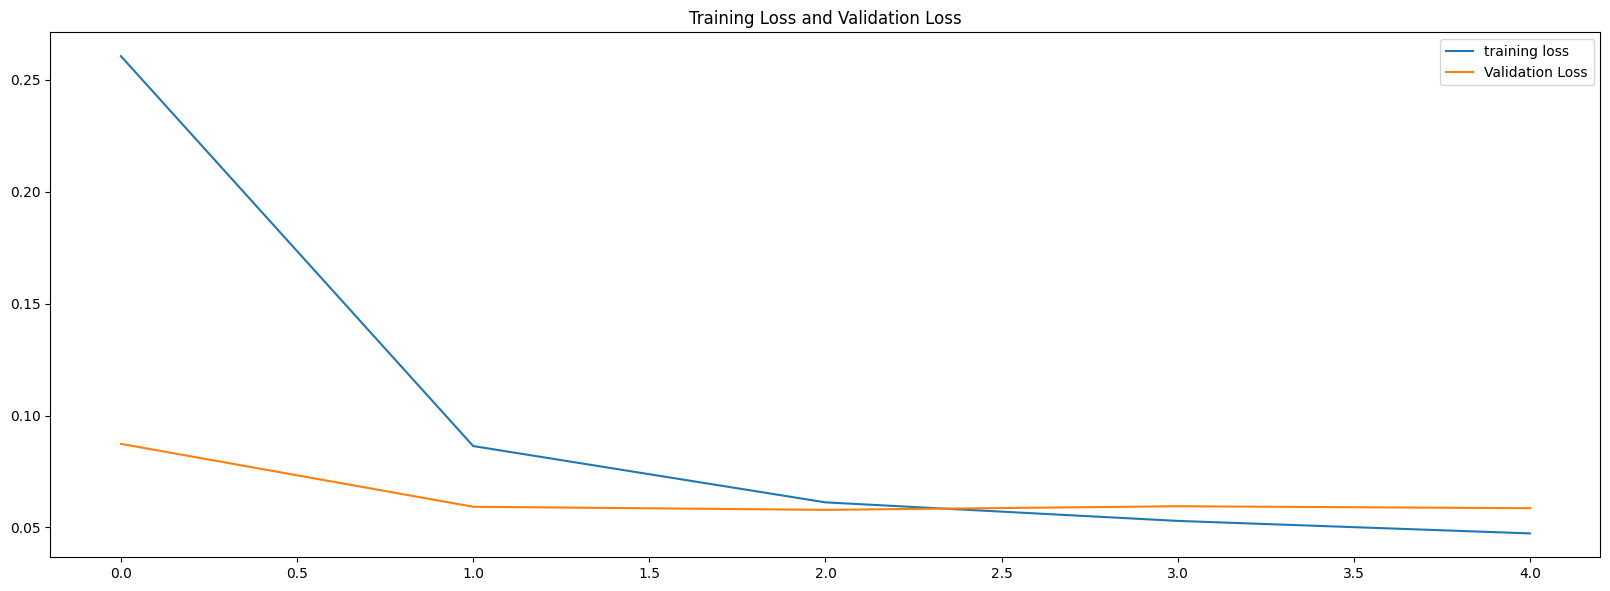

In [63]:
fig = plt.figure(figsize=[20, 15])
ax = fig.add_subplot(2, 1, 1)
ax.plot(history.history['loss'], label="training loss")
ax.plot(history.history['val_loss'], label="Validation Loss")
plt.title('Training Loss and Validation Loss')
ax.legend()



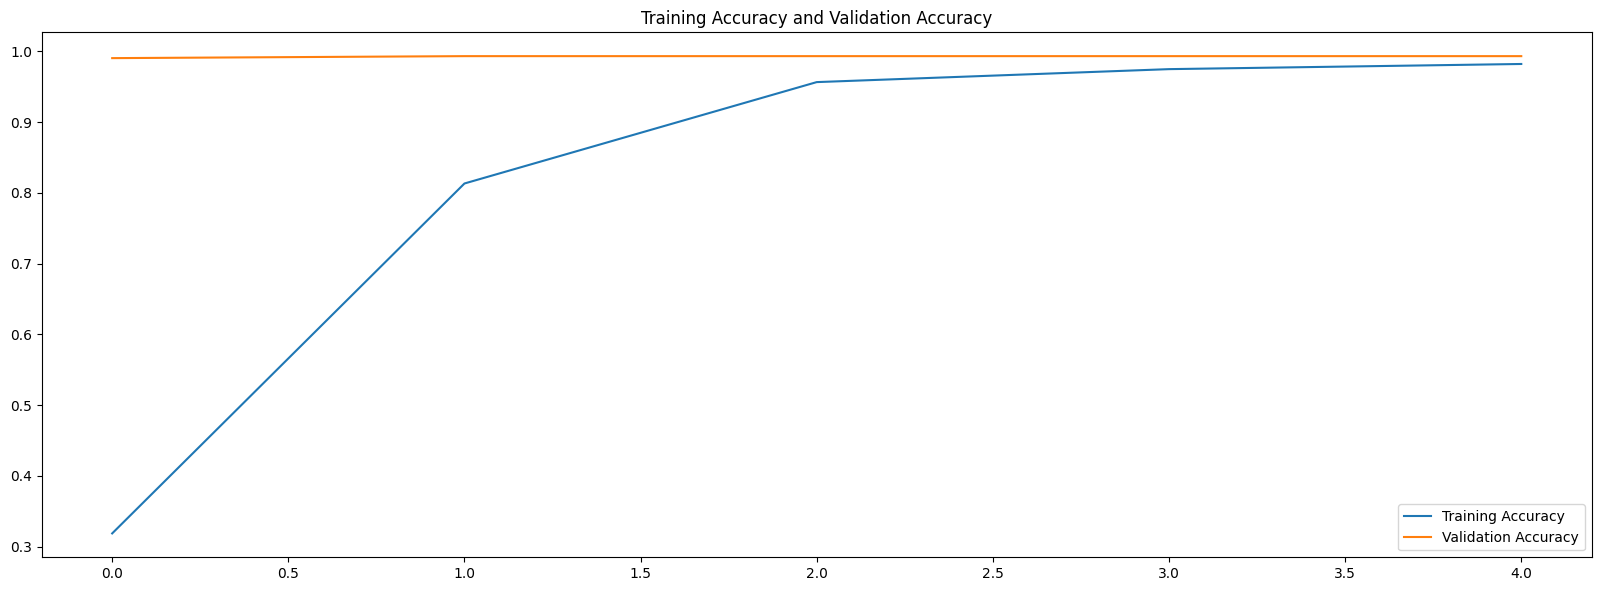

In [64]:



fig = plt.figure(figsize=[20, 15])
ax = fig.add_subplot(2, 1, 1)
ax.plot(history.history['accuracy'], label= "Training Accuracy")

ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.title('Training Accuracy and Validation Accuracy')
ax.legend()

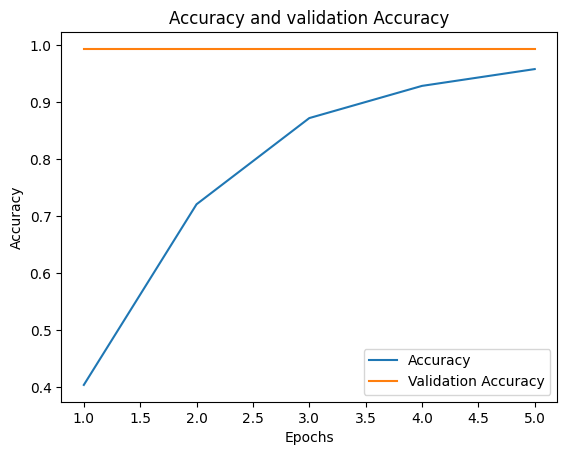

In [16]:
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Accuracy')
plt.plot(epochs, val_loss, label='Validation Accuracy')
plt.title('Accuracy and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

In [107]:
pred=model.predict(test_padded_X)
pred_2 = model.predict(train_padded_X)

# Convert predictions to one\s and zeros


In [79]:
print(pred_2_binary)

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


In [116]:
pred_binary = np.where(pred > 0.5, 1, 0)
pred_2_binary = np.where(pred_2 > 0.5, 1, 0)

In [93]:
from sklearn.metrics import f1_score, confusion_matrix

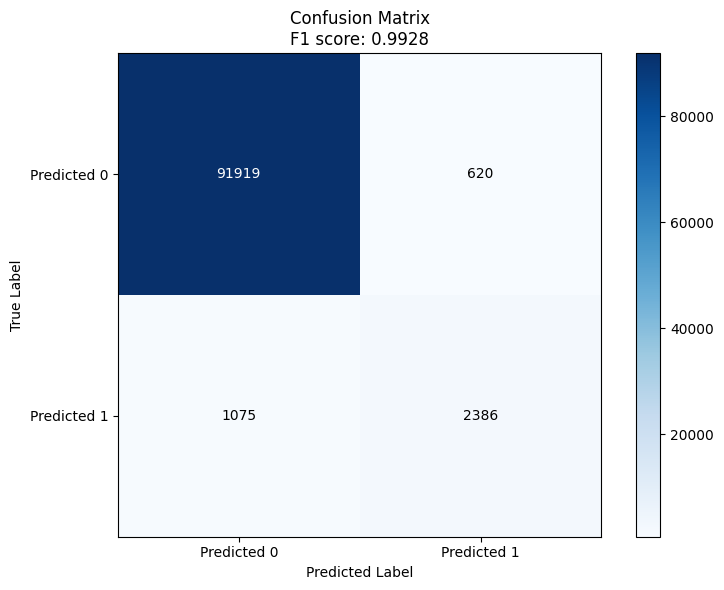

In [137]:
test_Y_single = np.argmax(test_Y, axis=1)
pred_single = np.argmax(pred_binary, axis=1)

#f1_score = f1_score(test_Y_single, pred_single, average='weighted')
f1_1 = f1_score(test_Y_single, pred_single, average='weighted')
# Get the number of classes
num_classes = len(list_classes)

# Calculate the confusion matrix
cm = np.zeros((2, 2))
for i in range(num_classes):
    true_positives = np.sum(np.logical_and(test_Y[:, i] == 1, pred_binary[:, i] == 1))
    false_positives = np.sum(np.logical_and(test_Y[:, i] == 0, pred_binary[:, i] == 1))
    true_negatives = np.sum(np.logical_and(test_Y[:, i] == 0, pred_binary[:, i] == 0))
    false_negatives = np.sum(np.logical_and(test_Y[:, i] == 1, pred_binary[:, i] == 0))

    cm[0, 0] += true_negatives
    cm[0, 1] += false_positives
    cm[1, 0] += false_negatives
    cm[1, 1] += true_positives

# Set the tick labels and locations
tick_labels = ['Predicted 0', 'Predicted 1']
tick_locations = np.arange(len(tick_labels))

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=tick_locations, yticks=tick_locations,
       xticklabels=tick_labels, yticklabels=tick_labels,
       ylabel='True Label',
       xlabel='Predicted Label',
       title=f'Confusion Matrix\nF1 score: {f1_1:.4f}')

# Loop over data dimensions and create text annotations with appropriate color
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'  # Adjust text color based on cell value
        ax.text(j, i, format(int(cm[i, j]), 'd'), ha="center", va="center", color=text_color)

plt.tight_layout()
plt.show()

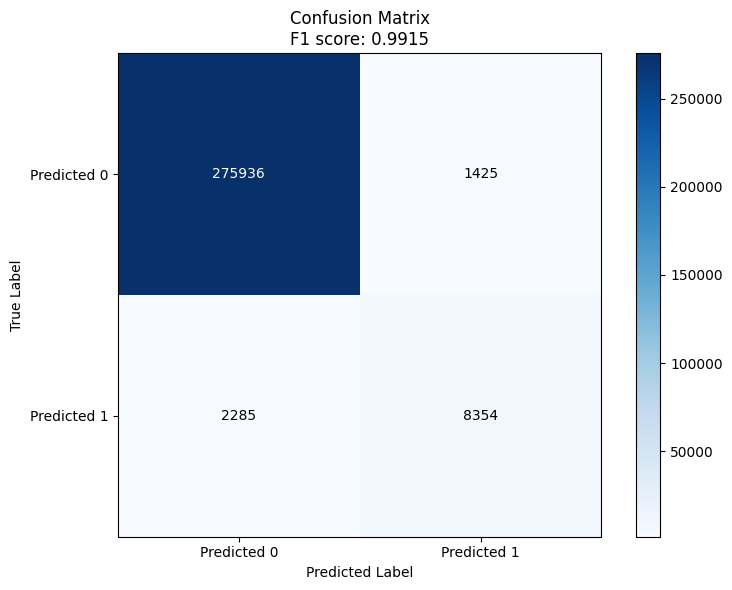

In [131]:
from sklearn.metrics import f1_score, confusion_matrix

train_Y_single = np.argmax(train_Y, axis=1)
pred2_single = np.argmax(pred_2_binary, axis=1)
cm = np.zeros((2, 2))
for i in range(num_classes):
    true_positives = np.sum(np.logical_and(train_Y[:, i] == 1, pred_2_binary[:, i] == 1))
    false_positives = np.sum(np.logical_and(train_Y[:, i] == 0, pred_2_binary[:, i] == 1))
    true_negatives = np.sum(np.logical_and(train_Y[:, i] == 0, pred_2_binary[:, i] == 0))
    false_negatives = np.sum(np.logical_and(train_Y[:, i] == 1, pred_2_binary[:, i] == 0))

    cm[0, 0] += true_negatives
    cm[0, 1] += false_positives
    cm[1, 0] += false_negatives
    cm[1, 1] += true_positives

# Set the tick labels and locations
tick_labels = ['Predicted 0', 'Predicted 1']
tick_locations = np.arange(len(tick_labels))

# Calculate the F1 score
f1_2 = f1_score(train_Y_single, pred2_single, average='weighted')

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=tick_locations, yticks=tick_locations,
       xticklabels=tick_labels, yticklabels=tick_labels,
       ylabel='True Label',
       xlabel='Predicted Label',
       title=f'Confusion Matrix\nF1 score: {f1_2:.4f}')

# Loop over data dimensions and create text annotations with appropriate color
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'  # Adjust text color based on cell value
        ax.text(j, i, format(int(cm[i, j]), 'd'), ha="center", va="center", color=text_color)

plt.tight_layout()
plt.show()